# Notebook 1 of 5: *Identification of nPOD Donors and Matching Process*

The entire nPOD biobank collection was screened for eligible study donors and then matched in trios, as described in the main text.  Each step and the corresponding code is provided below.  

## Dependencies

Set the file location for created data files.

In [1]:
libname files "/mnt/hgfs/myfolders"

The following macros were used to perform the 1:1:1 matching.  The Pharmacoepidemiology Toolbox was developed by Rassen JA and colleagues, is documented and downloadable [here.](http://www.drugepi.org/dope-downloads)   Running the below code chunk for the first time will create a classpath warning message that can be ignored.  Re-running the code will resolve this particular error, but not neccessary for execution of this notebook.  

In [2]:
%INCLUDE "macros/java_utils.sas";
%INCLUDE "macros/matching.sas";
%toolbox_Start(%QUOTE (macros/pharmacoepi.jar));

PROC javainfo classpaths;
run;

## Data Import & Coding of Needed Variables

Obtain all nPOD case records with with donor timeline data from nPOD DataShare.

In [3]:
PROC import out = icu datafile = 
            "Donor_TimeLine.xlsx"
     dbms = xlsx replace;
     options validvarname = V7;
run;


Flags represent potential issues with the timeline and are therefore exlcuded from consideration.

In [4]:
DATA icu1 (drop = npod_caseid);
     set icu;
     ptid = npod_caseid * 1;
     if Admit_Datetime_Flag          = 1 then 
        Hospitalization_Stay_Minutes = .;
     if Xclamp_Datetime_Flag         = 1 then 
        Hospitalization_Stay_Minutes = .;
     if Xclamp_Datetime_Flag         = 1 then 
        Transport_Duration_Minutes   = .;
     if Organ_Received_Datetime_Flag = 1 then 
        Transport_Duration_Minutes   = .;
     if Organ_Received_Datetime_Flag = 1 then 
        Processing_Time_Minutes      = .;
     if Organ_Frozen_Datetime_Flag   = 1 then 
        Processing_Time_Minutes      = .;
     Hospitalization_Stay_Days = Hospitalization_Stay_minutes / 1440;
     Processing_Time_Minutes1 = Processing_Time_Minutes * 1;
     transport_duration_hours=Transport_Duration_Minutes / 60;
 run;

Download demographics data from nPOD DataShare.  An ERROR message may appear, but safe to ignore.  

In [5]:
PROC import datafile = 'demographics.tsv' 
            out      = demographics 
            dbms     = dlm replace;
            delimiter = '09'x;
            getnames  = yes;
            guessingrows = 1000;
run;
quit;

Join timeline and demographics data tables together

In [6]:
PROC sort data = icu1;
     by ptid;
run;
 
PROC sort data = demographics;
     by ptid;
run;
 
DATA all;
     merge icu1 (in = a) demographics (in = b);
     by ptid;
     if a;
run;

Explore hospitalization stay time (in days).  It can be seen below that values are normally distributed across all nPOD samples.


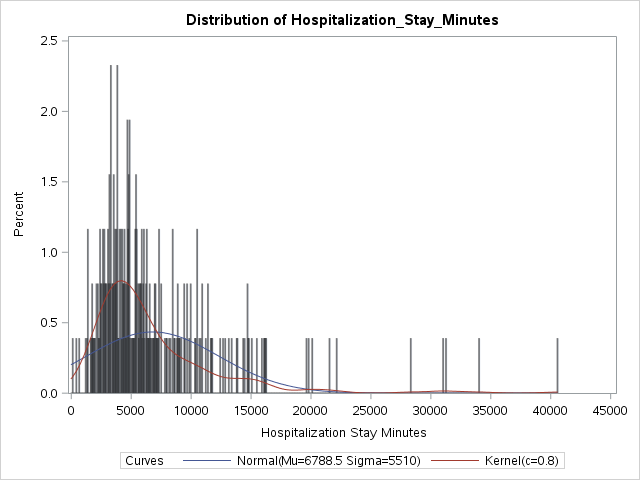
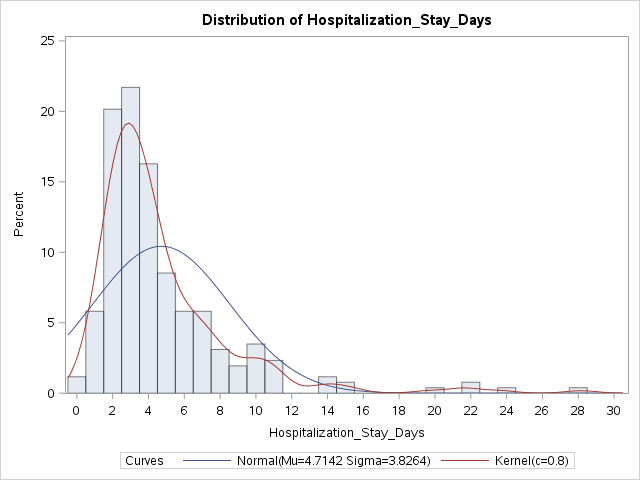

In [7]:
PROC univariate data = ALL noprint;
     histogram Hospitalization_Stay_minutes / kernel 
               (k = normal
                c = 0.8
                w = 2.5
                color = green)
     normal (mu = est
             sigma = est
             color = red
             w = 2.5 )
     midpoints = 0 to 40000 by 60;
run;
 
PROC univariate data = ALL noprint;
     histogram Hospitalization_Stay_Days / kernel 
               (k = normal
                c = 0.8
                w = 2.5
                color = green)
     normal (mu = est
             sigma = est
             color = red
             w = 2.5)
     midpoints = 0 to 30 by 1;
run;

Hospitalization stay time (in days) will be binned based on the definition used by In't Veld and colleagues (2010, Diabetes), and consistent with our previous work.  Other coding performed to re-format the data.  

In [8]:
DATA all1;
     set all;
     hospbin =.;
     if Hospitalization_Stay_Days^ =. and Hospitalization_Stay_Days < 3 then 
        hospbin = 3;
     if Hospitalization_Stay_Days >=3 and Hospitalization_Stay_Days < 6 then 
        hospbin = 6;
     if Hospitalization_Stay_Days >= 6 then 
        hospbin = 9;
     *if Hospitalization_Stay_Days>=9 then hospbin=12;
     if donor_type = "Autoab Pos" then 
        donor = 3;
     if donor_type = "T1D" then 
        donor = 1;
     if donor_type = "T1D Medalist" then 
        donor = 1;
     if donor_type = "T2D" then 
        donor = 2;
     if donor_type = "No diabetes" then
        donor = 0;
     if donor_type = "Gestational diabetes" then
        donor = 99;
     if donor_type = "Pregnancy" then 
        donor = 99;
     if donor_type = "Other" then 
        donor = 99;
     if donor_type = "Pending" then 
        donor = 99;
     if donor_type = "Autoab Pos by screening" then 
        donor = 3;
     if donor_type = "Preclinical T2D" then 
        donor = 99;
     if donor_type = "Cystic fibrosis" then 
        donor = 99;
     if donor_type = "Fulminant" then 
        donor = 99;
     if donor_type = "Transplant" then 
        donor = 99;
     if donor_type = "Virus infected cell line" then 
        donor = 99;
     if donor_type = "MODY" then 
        donor = 99;
     if donor_type = "CMA" then 
        donor = 99;
     if donor_type = "T2D+Incretin" then 
        donor = 2;
     if donor_type = "TMA" then 
        donor = 99;
     if donor_type = "Gastric Bypass" then 
        donor = 99;
     * coding for sex and ethnicity so as to be used for matching;
     sex = .;
     if oppc_gender = "Male" then 
        sex = 1;
     if oppc_gender = "Female" then 
        sex = 2;
     ethnicity = .;
     if oppc_ethnicity = "Caucasian" then 
        ethnicity = 1;
     if oppc_ethnicity = "Hispanic/Latino" then 
        ethnicity = 2;
     if oppc_ethnicity = "African Am" then 
        ethnicity = 3;
     if oppc_ethnicity = "Asian" then 
        ethnicity = 4;
     if oppc_ethnicity = "American Indian/Alaska Native" then 
        ethnicity = 5;
 run;

## Case Exclusion

Limiting donors to only nPOD cases, i.e. excluding donors from other collections stored at nPOD.  Calculated age for donor with pre-term births.  

In [9]:
DATA all1;
     set all1;
     if ptid < 6000 then 
        delete;
     if ptid > 6999 then 
        delete;
    *for those donors born pre-term, age was based on numbe of lived days after birth (i.e. number of days after gestational age);
    if ptid = 6120 then 
       oppc_ageR = 1 / 365;
    if ptid = 6164 then 
       oppc_ageR = 13.75 / 365;
    if ptid = 6192 then 
       oppc_ageR = 1 / 365;
    if ptid = 6200 then 
       oppc_ageR = 2.4 / 365;
    if ptid = 6201 then 
       oppc_ageR = 1 / 365;
    if ptid = 6210 then 
       oppc_ageR = 5.48 / 365;
    if ptid = 6214 then 
       oppc_ageR = 5.95 / 365;
run;

Further limiting donors to only control cases.

In [10]:
DATA all2;
     set all1;
     * only looking at controls;
     if donor^ = 0 then 
        delete; 
     if hospbin = . then 
        delete;
     if (Organ_Received_Datetime_Flag^ = 0 and 
         Organ_Frozen_Datetime_Flag ^= 0   and
         Admit_Datetime_Flag^ = 0          and 
         Braindeath_Datetime_Flag^ = 0     and
         clamp_Datetime_Flag^ = 0) then 
         delete;
run;

## Preparation for Donor Matching

For all donors, estimate 3-group propensity score using polytomous logistic regression

In [11]:
PROC logistic data = all2 
     order = data DESCENDING;
     class hospbin sex ethnicity;
     model hospbin(ref="3") = oppc_ager sex oppc_bmiR ethnicity /LINK=glogit;
     output out  = input_3way_cohort_long(KEEP = ptid hospbin prob) PRED = prob;
run;
quit

If propensity score not generated for a donor (because of unavailable/missing data), then delete case.  Calculate logit of propensity score.  

In [12]:
DATA input_3way_cohort_long;
     set input_3way_cohort_long;
     if prob = . then
        delete;
     logitpr = log(prob / (1 - prob));
     drop prob ;
     rename logitpr = prob;
run;

SD of logit is 1.4180436, .2 of that is .2836087, but that caliper width is recommended for 1:1 matching.  No studies have been done on optimal caliper width for 1:1:1 matching.  We therefore conservatively doubled the 1:1 caliper width allowing .5672174; authors of the Pharmacoepidemiology Toolbox recommend 3 times the 1:1.

In [13]:
PROC means data = input_3way_cohort_long 
     n 
     mean 
     std;
     var prob;
run;

Need to transform the data from one row per donor per level to one row per donor with one variable per level.

In [14]:
PROC transpose data = input_3way_cohort_long OUT = input_3way_cohort
     prefix = prob;
     by ptid hospbin;
run;
 
data input_3way_cohort (drop=_name_);
     set input_3way_cohort;
     ptid1 = put(ptid, 7.);
     drop ptid ;
     rename ptid1 = ptid;
run;

A priori to running the matching macros, case 6210 was identified as having some sample quality issues for this experiment, therefore is being removed as a candidate.  

In [15]:
DATA input_3way_cohort1;
     set input_3way_cohort;
     if ptid = 6210 then 
        delete;
run;

## Macro Matching

Use of the matching macro needs the location of the path to a temp directory.  This temp directory changes file path from one session to another.  The %LET statement stores the session path, and it is then used below when running the macro.  If problems arise, an alternative solution is to run  %put %sysfunc(getoption(work)); then copy the file path and paste it after the %QUOTE in the macro below (in particular, you need all the numbers and letters that appear after SAS_work).  

In [19]:
* Run 1:1:1 nearest neighbor match;

%match_NearestNeighborMatch    (input_3way_cohort1,
                             output_3way_cohort,
                             %QUOTE(&file_path),
                             var_patient_id = ptid,
                             var_exposure   = hospbin,
                             var_ps         = prob1 prob2 prob3,
                             exp_groups     = 3 6 9,
                             caliper        = .5672174,
                             ratio          = 1);
 
DATA match_import1 (keep = pat_id ptid SET_NUM);
     set match_import;
     ptid = pat_id * 1;
run;
 
DATA match_import1 (keep = ptid set_num);
     set match_import1;
run;
 
PROC sort data = match_import1;
     by ptid;
run;
 
PROC sort data = all2;
     by ptid;
run;
 
DATA study;
     merge match_import1 (in = a) all2 (in = b);
     by ptid;
     if a;
run;
 
PROC freq data = study;
     tables hospbin;
run;


hospbin,Frequency,Percent,CumulativeFrequency,CumulativePercent
3,15,33.33,15,33.33
6,15,33.33,30,66.67
9,15,33.33,45,100.00


## Verification of Results

Need to determine if there are any differences in  age, sex, BMI, and ethnicity between the three groups, as these variables were used for matching.  Here, distribution of variables is examined.  


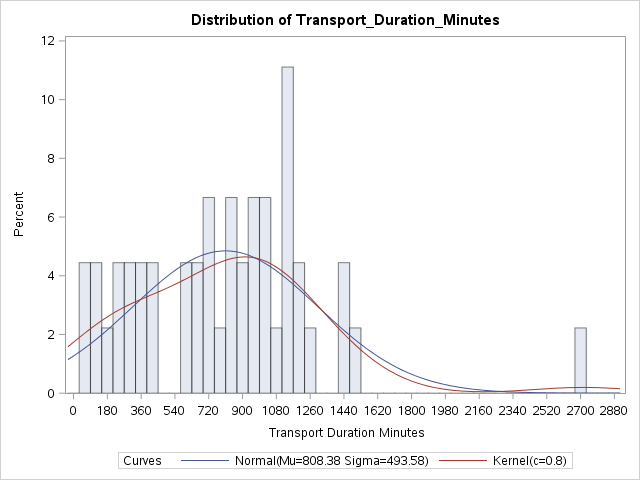
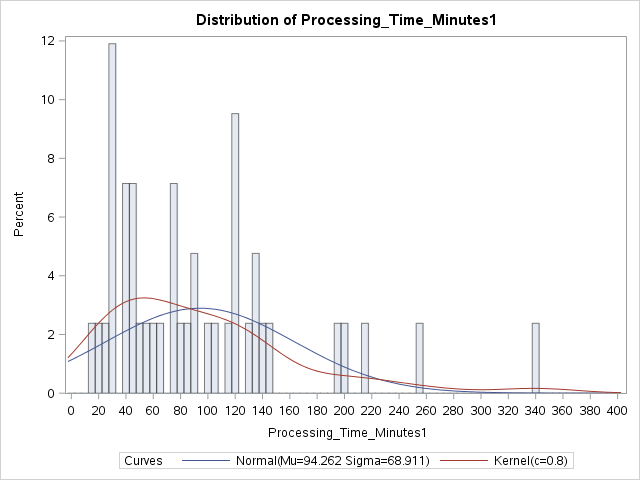

In [20]:
PROC univariate data = study;
     var oppc_ager 
     oppc_bmir 
     Transport_Duration_Minutes 
     Processing_Time_Minutes1;
run;
 
PROC univariate data = study noprint;
     histogram Transport_Duration_Minutes / kernel 
               (k     = normal
                c     = 0.8 
                w     = 2.5 
                color = green)
     normal (mu    = est 
             sigma = est 
             color = red 
             w     = 2.5 )
     midpoints = 0 to 2880 by 60; 
run;
 
PROC univariate data = study noprint;
     histogram Processing_Time_Minutes1 / kernel 
               (k     = normal
                c     = 0.8 
                w     = 2.5 
                color = green)
     normal (mu    = est 
             sigma = est 
             color = red 
             w     = 2.5)
     midpoints = 0 to 400 by 5;
run;

After matching completed, list of donors was reviewed.  It was determined that tissue was not available for 6001 and 6021, so all blocks that contain these samples were removed from consideration of this experiment and matching verification proceeded.  

In [21]:
DATA study1;
     set study;
     if set_num = 2  then 
        delete;
     if set_num = 12 then 
        delete;
run;

DATA grouping_list (keep = case match_group oppc_ageR);
     set study1;
     rename ptid=case;
     rename set_num=match_group;
run;

continuous parametric: ANOVA for multi-group comparisons


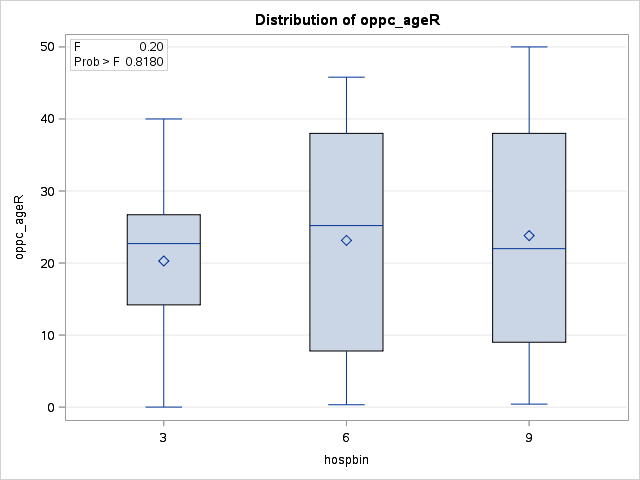
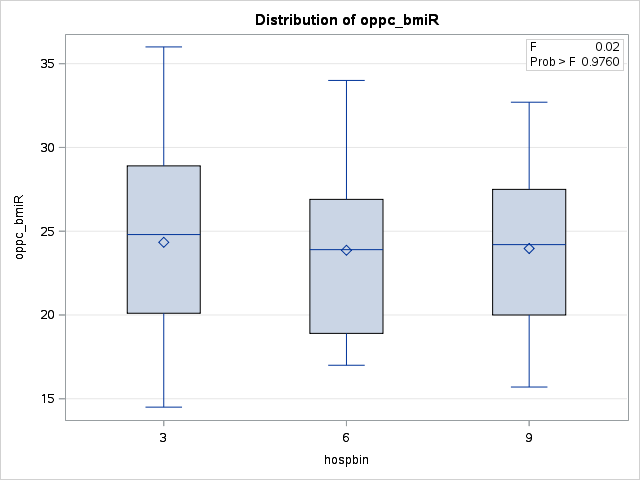
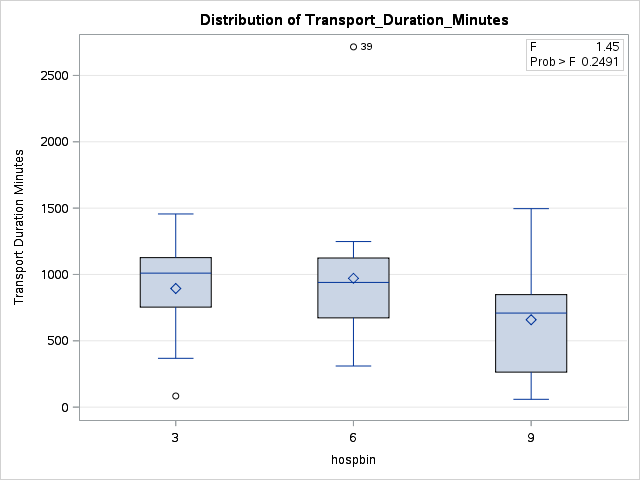

In [22]:
%macro anova (X); 
PROC anova data = study1;
     class hospbin;
     model &X = hospbin;
run;

%mend anova;
%anova (oppc_ageR); 
run;
%anova (oppc_bmiR); 
run;
*transport duration was not formally matched, but checked anyway;
%anova (Transport_Duration_Minutes); 
run;

 continuous non-parametric: wilcoxon rank sum


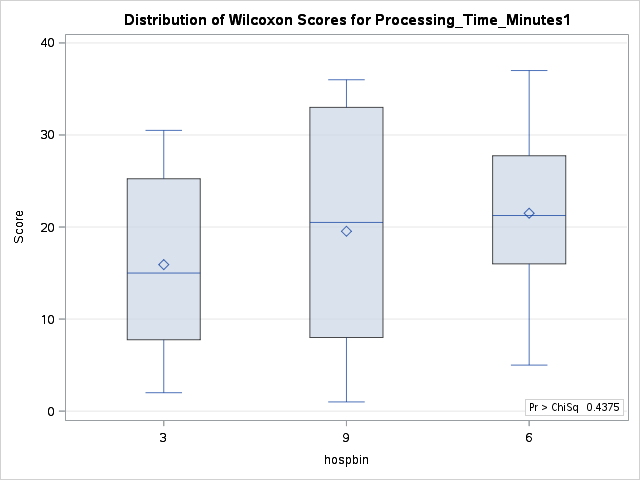

In [23]:
%macro npar1way (X);
PROC npar1way data = study1 wilcoxon;
     class hospbin;
     var &X;
     title "wilcoxon rank sum for &X on group1";
     %mend npar1way;
     *processing time was not formally matched, but checked anyway;
     %npar1way (Processing_Time_Minutes1);
run;

p-values were calculated for both 2- and multi-class categorical nominal data.     Fisher's exact test was used when values from 1 or more cells in a contingency       table (2 x 2 or R x C) were less than 5.  Pearson's chi square was used where        values in all cells exceeded 5. If values from 2 or more cells in any table were     equal to 0, p-values were not generated.

In [24]:
%macro freq (X);
PROC freq data = study1;
     tables &X * hospbin / measures chisq;
     %mend freq;
run;
 
%macro freq1 (X);
PROC freq data = study1;
     tables &X * hospbin / measures fisher;
     %mend freq1;
     %freq1(ethnicity); run;
     %freq1 (sex);
run;

## Additional Grouping

An additional factor is created to specifically test whether differences in the analysis are seen based on age.  Groupings based on papers by Gregg et al, J Clin Endocrinol Metab, 2012 (examines Ki67/insulin staining by age groups)  and Cole TJ, 2009, Adv Exp Med Biol, 639:1-13 (examines organ development by age).

In [25]:
DATA study1;
    set study1;
    if oppc_ageR<1 then age_group=1;                     /*developmental and neonates*/
    if oppc_ageR>=1 and oppc_ageR<12 then age_group=1;   /*child*/
    if oppc_ageR>=12 and oppc_ageR<20 then age_group=2;  /*adolescent*/
    if oppc_ageR>=20 then age_group=3;                   /*adult*/
run;

PROC sort data=study1;
     by hospbin;
run;

PROC freq data=study1;
     tables age_group;
run;

PROC freq data=study1;
     tables age_group;
     by hospbin;
run;

proc print data=study1;
run;

age_group,Frequency,Percent,CumulativeFrequency,CumulativePercent
1,11,28.21,11,28.21
2,5,12.82,16,41.03
3,23,58.97,39,100.00
age_group,Frequency,Percent,CumulativeFrequency,CumulativePercent
1,3,23.08,3,23.08
2,2,15.38,5,38.46
3,8,61.54,13,100.00
age_group,Frequency,Percent,CumulativeFrequency,CumulativePercent
1,4,30.77,4,30.77
2,2,15.38,6,46.15


Need to test for collinearity of age group with hospitalization time group, since both will be included in the model.  

In [26]:
%macro freq (X, Y);

PROC freq data=study1;
     tables &X*&Y/measures chisq exact;

%mend freq;

/*ORDINAL VS ORDINAL or 2-class nominal vs. ordinal Tau-b if equal r x c, and tau-c if unequal r x c*/
%freq (hospbin,age_group); run;

## Matching Schema Save

The final verified matching scheme is saved for later reference.

In [27]:
libname files "/mnt/hgfs/myfolders";

DATA files.grouping_list (keep = case match_group age_group oppc_ageR);
     set study1;
     rename ptid=case;
     rename set_num=match_group;
run;

## Table 1 - Demographics

### Additional data files needed

The study1 data file does not have info on c-peptide.  Downloaded that dataset from nPOD DataShare and merged it.

In [28]:
PROC import datafile = 'Diabetes Information.tsv' 
            out      = diabetesinfo 
            dbms     = dlm replace;
            delimiter = '09'x;
            getnames  = yes;
            guessingrows = 1000;
run;
quit;


data diabetesinfo1;
     set diabetesinfo;
     npodcaseID1=npodcaseid*1;
     rename nPODCaseID1=ptid;
     cpeptide=oppc_c_peptideR*1;
 run;

PROC sort data=diabetesinfo1;
     by ptid;
run;

PROC sort data=study1;
     by ptid;
run;

data study2;
     merge study1 (in=a) diabetesinfo1 (in=b);
     by ptid;
     if a;
run;

proc print data=study2;
run;


Obs,set_num,ptid,Donor_Type,Organ_Received_Datetime_Flag,Organ_Frozen_Datetime_Flag,Admit_Datetime_Flag,Braindeath_Datetime_Flag,Xclamp_Datetime_Flag,Hospitalization_Stay_Minutes,Transport_Duration_Minutes,Processing_Time_Minutes,Hospitalization_Stay_Days,Processing_Time_Minutes1,transport_duration_hours,DonorType,abo_subtype,oppc_PancreasWT,oppc_Gender,oppc_Ethnicity,oppc_ABO,multi_organ_donor,non_hrt_beat_donor,oppc_ageR,oppc_heightR,oppc_weightR,oppc_bmiR,cod_final,death_mech_final,replace,hospbin,donor,sex,ethnicity,clamp_Datetime_Flag,age_group,nPODCaseID,diabetes_Duration_yrs,oppc_C_peptideR,oppc_HbA1cR,diabetes_history,insulin_depd,insulin_meds_taken,cpeptide
1,6,6003,No diabetes,0,0,0,0,0,3994,84,30,2.7736,30,1.4000,No diabetes,O,.,Female,Caucasian,O+,Yes,No,23,160,75,29.3,HEAD TRAUMA,blunt injury,TRUE,3,0,2,1,.,3,6003,.,,.,No,,None,.
2,1,6005,No diabetes,0,0,0,0,0,9184,1496,30,6.3778,30,24.9333,No diabetes,A1,.,Female,Caucasian,A-,Yes,No,5,104,17,15.7,CEREBROVASCULAR/STROKE,intracranial hemorrhage/stroke,TRUE,9,0,2,1,.,1,6005,.,,.,No,,None,.
3,3,6007,No diabetes,0,0,0,0,0,9985,264,20,6.9340,20,4.4000,No diabetes,O,.,Male,African Am,O+,Yes,No,9,143,41,20,ANOXIA,,TRUE,9,0,1,3,.,1,6007,.,,.,No,,None,.
4,7,6008,No diabetes,0,0,0,0,0,15058,112,30,10.4569,30,1.8667,No diabetes,O,.,Female,Caucasian,O+,Yes,Yes,50,160,62,24.2,HEAD TRAUMA,blunt injury,TRUE,9,0,2,1,.,3,6008,.,,.,No,,None,.
5,5,6011,No diabetes,0,0,0,0,0,40531,59,42,28.1465,42,0.9833,No diabetes,O,.,Female,African Am,O+,Yes,No,46,163,70,26.3,CEREBROVASCULAR/STROKE,intracranial hemorrhage/stroke,TRUE,9,0,2,3,.,3,6011,.,,.,No,,None,.
6,9,6019,No diabetes,0,0,0,0,0,11642,215,40,8.0847,40,3.5833,No diabetes,O,.,Male,Caucasian,O-,Yes,No,42,175,95,31,HEAD TRAUMA,intracranial hemorrhage/stroke,TRUE,9,0,1,1,.,3,6019,.,0.47,5.6,No,,None,0.47
7,10,6047,No diabetes,0,0,0,0,0,4851,737,30,3.3688,30,12.2833,No diabetes,O,53.02,Male,Caucasian,O-,Yes,No,7.8,111.8,30,23.9,ANOXIA,drowning,TRUE,6,0,1,1,.,1,6047,.,0.65,5.5,No,,No,0.65
8,11,6048,No diabetes,0,0,0,0,0,1927,368,55,1.3382,55,6.1333,No diabetes,O,139,Male,Caucasian,O-,Yes,No,30,165.1,56,20.6,CEREBROVASCULAR/STROKE,intracranial hemorrhage/stroke,TRUE,3,0,1,1,.,3,6048,.,17.91,.,No,,No,17.91
9,10,6057,No diabetes,0,0,0,0,0,12416,709,255,8.6222,255,11.8167,No diabetes,O,104.36,Male,Caucasian,O+,Yes,No,22,188,92,26,HEAD TRAUMA,blunt injury,TRUE,9,0,1,1,.,3,6057,.,16.23,.,No,,No,16.23
10,6,6060,No diabetes,0,0,0,0,0,13119,396,215,9.1104,215,6.6000,No diabetes,A1,104,Male,Caucasian,A+,Yes,No,24,175.3,100,32.7,HEAD TRAUMA,blunt injury,TRUE,9,0,1,1,.,3,6060,.,13.63,.,No,,No,13.63


Data on medications adminstered within 24 hours prior to organ recovery.  Downloaded from nPOD DataShare and merged it.

In [37]:
PROC import datafile = 'meds.tsv' 
            out      = meds 
            dbms     = dlm replace;
            delimiter = '09'x;
            getnames  = yes;
            guessingrows = 1000;
run;
quit;

data meds1 (drop=npodcaseid);
     set meds;
     npodcaseID1=npodcaseid*1;
     rename nPODCaseID1=ptid;
run;

PROC sort data=meds1;
     by ptid;
run;

PROC sort data=study2;
     by ptid;
run;

data study3;
     merge study2 (in=a) meds1 (in=b);
     by ptid;
     if a;
run;

proc print data=study3;
run;

Obs,set_num,ptid,Donor_Type,Organ_Received_Datetime_Flag,Organ_Frozen_Datetime_Flag,Admit_Datetime_Flag,Braindeath_Datetime_Flag,Xclamp_Datetime_Flag,Hospitalization_Stay_Minutes,Transport_Duration_Minutes,Processing_Time_Minutes,Hospitalization_Stay_Days,Processing_Time_Minutes1,transport_duration_hours,DonorType,abo_subtype,oppc_PancreasWT,oppc_Gender,oppc_Ethnicity,oppc_ABO,multi_organ_donor,non_hrt_beat_donor,oppc_ageR,oppc_heightR,oppc_weightR,oppc_bmiR,cod_final,death_mech_final,replace,hospbin,donor,sex,ethnicity,clamp_Datetime_Flag,age_group,nPODCaseID,diabetes_Duration_yrs,oppc_C_peptideR,oppc_HbA1cR,diabetes_history,insulin_depd,insulin_meds_taken,cpeptide,dataSetsDemographicsDonorType,pt_steroids,pt_diuretics,pt_t3,pt_t4,anticonv,antihype,vasodil,ddavp,heparin,arginine,insulin,other_meds1,other_meds2,other_meds3
1,6,6003,No diabetes,0,0,0,0,0,3994,84,30,2.7736,30,1.4000,No diabetes,O,.,Female,Caucasian,O+,Yes,No,23,160,75,29.3,HEAD TRAUMA,blunt injury,TRUE,3,0,2,1,.,3,6003,.,,.,No,,None,.,No diabetes,Y,Y,N,Y,Y,N,N,N,Y,N,N,CEFEPIME,DOPAMINE,CLINDAMYCIN
2,1,6005,No diabetes,0,0,0,0,0,9184,1496,30,6.3778,30,24.9333,No diabetes,A1,.,Female,Caucasian,A-,Yes,No,5,104,17,15.7,CEREBROVASCULAR/STROKE,intracranial hemorrhage/stroke,TRUE,9,0,2,1,.,1,6005,.,,.,No,,None,.,No diabetes,Y,Y,N,N,N,N,N,N,Y,N,Y,MYCAMINE,NARCAN,REGATINE
3,3,6007,No diabetes,0,0,0,0,0,9985,264,20,6.9340,20,4.4000,No diabetes,O,.,Male,African Am,O+,Yes,No,9,143,41,20,ANOXIA,,TRUE,9,0,1,3,.,1,6007,.,,.,No,,None,.,No diabetes,Y,Y,N,Y,Y,N,Y,N,Y,N,Y,ANCEF,,
4,7,6008,No diabetes,0,0,0,0,0,15058,112,30,10.4569,30,1.8667,No diabetes,O,.,Female,Caucasian,O+,Yes,Yes,50,160,62,24.2,HEAD TRAUMA,blunt injury,TRUE,9,0,2,1,.,3,6008,.,,.,No,,None,.,No diabetes,N,N,N,N,Y,N,N,N,N,N,Y,CEFEPINE,ANCF,KCL
5,5,6011,No diabetes,0,0,0,0,0,40531,59,42,28.1465,42,0.9833,No diabetes,O,.,Female,African Am,O+,Yes,No,46,163,70,26.3,CEREBROVASCULAR/STROKE,intracranial hemorrhage/stroke,TRUE,9,0,2,3,.,3,6011,.,,.,No,,None,.,No diabetes,Y,Y,N,N,N,N,N,N,Y,N,N,PROPOFOL,PENTOBARB,VANC
6,9,6019,No diabetes,0,0,0,0,0,11642,215,40,8.0847,40,3.5833,No diabetes,O,.,Male,Caucasian,O-,Yes,No,42,175,95,31,HEAD TRAUMA,intracranial hemorrhage/stroke,TRUE,9,0,1,1,.,3,6019,.,0.47,5.6,No,,None,0.47,No diabetes,Y,Y,N,Y,Y,Y,N,N,Y,N,Y,NARCAN,FACTOR 7,D5D
7,10,6047,No diabetes,0,0,0,0,0,4851,737,30,3.3688,30,12.2833,No diabetes,O,53.02,Male,Caucasian,O-,Yes,No,7.8,111.8,30,23.9,ANOXIA,drowning,TRUE,6,0,1,1,.,1,6047,.,0.65,5.5,No,,No,0.65,No diabetes,Y,Y,N,Y,Y,N,Y,N,Y,Y,Y,CLEOCIN,,
8,11,6048,No diabetes,0,0,0,0,0,1927,368,55,1.3382,55,6.1333,No diabetes,O,139,Male,Caucasian,O-,Yes,No,30,165.1,56,20.6,CEREBROVASCULAR/STROKE,intracranial hemorrhage/stroke,TRUE,3,0,1,1,.,3,6048,.,17.91,.,No,,No,17.91,No diabetes,Y,Y,N,N,N,N,Y,Y,Y,Y,N,CEFEPIME,VANCOMYCIN,PROTONIX
9,10,6057,No diabetes,0,0,0,0,0,12416,709,255,8.6222,255,11.8167,No diabetes,O,104.36,Male,Caucasian,O+,Yes,No,22,188,92,26,HEAD TRAUMA,blunt injury,TRUE,9,0,1,1,.,3,6057,.,16.23,.,No,,No,16.23,No diabetes,N,Y,N,N,N,N,Y,N,Y,N,N,,,
10,6,6060,No diabetes,0,0,0,0,0,13119,396,215,9.1104,215,6.6000,No diabetes,A1,104,Male,Caucasian,A+,Yes,No,24,175.3,100,32.7,HEAD TRAUMA,blunt injury,TRUE,9,0,1,1,.,3,6060,.,13.63,.,No,,No,13.63,No diabetes,N,Y,N,Y,N,N,Y,N,Y,N,N,"COLACE, PROTONIX, PROPOFOL","CLOACIN, LEVAQUIN, MORPHINE","VANCOMYCIN, AMINOPHLLINE"


Examined med list (other_meds1, 2, and 3) and it needs to be cleaned up so that each medication is placed into a separate field for further analysis.  Given the number of records, the dataset was exported and pre-processed manually, then re-imported into the datafile.  

In rare cases, dosages were given.  This information was not used in the analysis and thus removed as part of the pre-processing.  Generic or brand name of medication was used, but not both. Abbreviations were expanded to full medication names, where distinguishable. Blanks were recoded to 'none'.   Misspellings were accounted for in the mappings.    

In [65]:
PROC export data=study3 
     outfile="study3.csv" 
     dbms=csv
     replace;
run; 

PROC import datafile = 'study4.csv' 
            out      = study4
            dbms     = csv replace;
            getnames  = yes;
            guessingrows = 1000;
run;
quit;

PROC print data=study4;
run;


Obs,set_num,ptid,Donor_Type,Organ_Received_Datetime_Flag,Organ_Frozen_Datetime_Flag,Admit_Datetime_Flag,Braindeath_Datetime_Flag,Xclamp_Datetime_Flag,Hospitalization_Stay_Minutes,Transport_Duration_Minutes,Processing_Time_Minutes,Hospitalization_Stay_Days,Processing_Time_Minutes1,transport_duration_hours,DonorType,abo_subtype,oppc_PancreasWT,oppc_Gender,oppc_Ethnicity,oppc_ABO,multi_organ_donor,non_hrt_beat_donor,oppc_ageR,oppc_heightR,oppc_weightR,oppc_bmiR,cod_final,death_mech_final,replace,hospbin,donor,sex,ethnicity,clamp_Datetime_Flag,age_group,nPODCaseID,diabetes_Duration_yrs,oppc_C_peptideR,oppc_HbA1cR,diabetes_history,insulin_depd,insulin_meds_taken,cpeptide,dataSetsDemographicsDonorType,pt_steroids,pt_diuretics,pt_t3,pt_t4,anticonv,antihype,vasodil,ddavp,heparin,arginine,insulin,dmed_other1,dmed_other2,dmed_other3,dmed_other4,dmed_other5,dmed_other6,dmed_other7,dmed_other8,dmed_other9
1,6,6003,No diabetes,0,0,0,0,0,3994,84,30,2.773611111,30,1.4,No diabetes,O,.,Female,Caucasian,O+,Yes,No,23,160,75,29.3,HEAD TRAUMA,blunt injury,TRUE,3,0,2,1,,3,6003,,.,.,No,,None,.,No diabetes,Y,Y,N,Y,Y,N,N,N,Y,N,N,CEFEPIME,none,none,DOPAMINE,none,none,CLINDAMYCIN,none,none
2,1,6005,No diabetes,0,0,0,0,0,9184,1496,30,6.377777778,30,24.93333333,No diabetes,A1,.,Female,Caucasian,A-,Yes,No,5,104,17,15.7,CEREBROVASCULAR/STROKE,intracranial hemorrhage/stroke,TRUE,9,0,2,1,,1,6005,,.,.,No,,None,.,No diabetes,Y,Y,N,N,N,N,N,N,Y,N,Y,MYCAMINE,none,none,NARCAN,none,none,REGATINE,none,none
3,3,6007,No diabetes,0,0,0,0,0,9985,264,20,6.934027778,20,4.4,No diabetes,O,.,Male,African Am,O+,Yes,No,9,143,41,20,ANOXIA,,TRUE,9,0,1,3,,1,6007,,.,.,No,,None,.,No diabetes,Y,Y,N,Y,Y,N,Y,N,Y,N,Y,ANCEF,none,none,none,none,none,none,none,none
4,7,6008,No diabetes,0,0,0,0,0,15058,112,30,10.45694444,30,1.866666667,No diabetes,O,.,Female,Caucasian,O+,Yes,Yes,50,160,62,24.2,HEAD TRAUMA,blunt injury,TRUE,9,0,2,1,,3,6008,,.,.,No,,None,.,No diabetes,N,N,N,N,Y,N,N,N,N,N,Y,CEFEPINE,none,none,ANCF,none,none,KCL,none,none
5,5,6011,No diabetes,0,0,0,0,0,40531,59,42,28.14652778,42,0.983333333,No diabetes,O,.,Female,African Am,O+,Yes,No,46,163,70,26.3,CEREBROVASCULAR/STROKE,intracranial hemorrhage/stroke,TRUE,9,0,2,3,,3,6011,,.,.,No,,None,.,No diabetes,Y,Y,N,N,N,N,N,N,Y,N,N,PROPOFOL,none,none,PENTOBARB,none,none,VANC,none,none
6,9,6019,No diabetes,0,0,0,0,0,11642,215,40,8.084722222,40,3.583333333,No diabetes,O,.,Male,Caucasian,O-,Yes,No,42,175,95,31,HEAD TRAUMA,intracranial hemorrhage/stroke,TRUE,9,0,1,1,,3,6019,,0.47,5.6,No,,None,0.47,No diabetes,Y,Y,N,Y,Y,Y,N,N,Y,N,Y,NARCAN,none,none,FACTOR 7,none,none,D5D,none,none
7,10,6047,No diabetes,0,0,0,0,0,4851,737,30,3.36875,30,12.28333333,No diabetes,O,53.02,Male,Caucasian,O-,Yes,No,7.8,111.8,30,23.9,ANOXIA,drowning,TRUE,6,0,1,1,,1,6047,,0.65,5.5,No,,No,0.65,No diabetes,Y,Y,N,Y,Y,N,Y,N,Y,Y,Y,CLEOCIN,none,none,none,none,none,none,none,none
8,11,6048,No diabetes,0,0,0,0,0,1927,368,55,1.338194444,55,6.133333333,No diabetes,O,139,Male,Caucasian,O-,Yes,No,30,165.1,56,20.6,CEREBROVASCULAR/STROKE,intracranial hemorrhage/stroke,TRUE,3,0,1,1,,3,6048,,17.91,.,No,,No,17.91,No diabetes,Y,Y,N,N,N,N,Y,Y,Y,Y,N,CEFEPIME,none,none,VANCOMYCIN,none,none,PROTONIX,none,none
9,10,6057,No diabetes,0,0,0,0,0,12416,709,255,8.622222222,255,11.81666667,No diabetes,O,104.36,Male,Caucasian,O+,Yes,No,22,188,92,26,HEAD TRAUMA,blunt injury,TRUE,9,0,1,1,,3,6057,,16.23,.,No,,No,16.23,No diabetes,N,Y,N,N,N,N,Y,N,Y,N,N,none,none,none,none,none,none,none,none,none
10,6,6060,No diabetes,0,0,0,0,0,13119,396,215,9.110416667,215,6.6,No diabetes,A1,104,Male,Caucasian,A+,Yes,No,24,175.3,100,32.7,HEAD TRAUMA,blunt injury,TRUE,9,0,1,1,,3,6060,,13.63,.,No,,No,13.63,No diabetes,N,Y,N,Y,N,N,Y,N,Y,N,N,COLACE,PROTONIX,PROPOFOL,CLOACIN,LEVAQUIN,MORPHINE,VANCOMYCIN,AMINOPHLLINE,none


Processing of medications (entered in open text fields) to categories proceeded in a series of steps outlined below.  

In [73]:
/********step 1: Imported groupings of previously identified medications into categories 
          (see Kaddis et al, AJT, 2010; Campbell-Thompson et al, JAMA, 2012) for use in comparison.*/

PROC import datafile='med_list_categories.txt' out=categories dbms=dlm replace;
     delimiter='09'x;
     getnames=yes;
     guessingrows=1000;
run;
quit;

/********step 2: merge categories with med list*/

DATA opentextmerge;
     merge study4 categories;
run;

/********step 3: clean up medication list, i.e. change letters to all lowercase, remove white space between words*/

DATA opentextmerge1;
    set opentextmerge; 
    dmed_other1	=	lowcase	(	dmed_other1	)	;
    dmed_other2	=	lowcase	(	dmed_other2	)	;
    dmed_other3	=	lowcase	(	dmed_other3	)	;
    dmed_other4	=	lowcase	(	dmed_other4	)	;
    dmed_other5	=	lowcase	(	dmed_other5	)	;
    dmed_other6	=	lowcase	(	dmed_other6	)	;
    dmed_other7	=	lowcase	(	dmed_other7	)	;
    dmed_other8	=	lowcase	(	dmed_other8	)	;
    dmed_other9	=	lowcase	(	dmed_other9	)	;
   
    anestetics	=	lowcase	(	anestetics	)	;
    antibiotics	=	lowcase	(	antibiotics	)	;
    cardiovascular	=	lowcase	(	cardiovascular	)	;
    hormonal	=	lowcase	(	hormonal	)	;
    others	=	lowcase	(	others	)	;
    fluids_electrolytes	=	lowcase	(	fluids_electrolytes	)	;

    dmed_other1	=	kcompress	(	dmed_other1	)	;
    dmed_other2	=	kcompress	(	dmed_other2	)	;
    dmed_other3	=	kcompress	(	dmed_other3	)	;
    dmed_other4	=	kcompress	(	dmed_other4	)	;
    dmed_other5	=	kcompress	(	dmed_other5	)	;
    dmed_other6	=	kcompress	(	dmed_other6	)	;
    dmed_other7	=	kcompress	(	dmed_other7	)	;
    dmed_other8	=	kcompress	(	dmed_other8	)	;
    dmed_other9	=	kcompress	(	dmed_other9	)	;

    anestetics	=	kcompress	(	anestetics	)	;
    antibiotics	=	kcompress	(	antibiotics	)	;
    cardiovascular	=	kcompress	(	cardiovascular	)	;
    hormonal	=	kcompress	(	hormonal	)	;
    others	=	kcompress	(	others	)	;
    fluids_electrolytes	=	kcompress	(	fluids_electrolytes	)	;
run;

/********step 4: double-check categories dataset to make sure that a drug does not appear in more than 1 category*/

PROC iml;
    use opentextmerge1;
    /*creation of matrix from variables (n by 1 column matrix for each variable*/
    read all var {'anestetics'} into anestetics;
    read all var {'antibiotics'} into antibiotics;
    read all var {'cardiovascular'} into cardiovascular;
    read all var {'hormonal'} into hormonal;
    read all var {'others'} into others;
    read all var {'fluids_electrolytes'} into fluids_electrolytes;

    /*matrix initiation*/
    b=138; /*number of medications in longest list of (Anestetics, Antibiotics, Cardiovascular, Hormonal, Others, Fluids_Electrolytes)*/
    c=6; /*number of categories in list*/
    d=138;

    /*create macro and DO loop for matrix calculations*/
    %macro evaluation;   

    dmedrecode=j(b,c,0);

	do n=1 to b; /*number of records being examined for each variable*/
		do p=1 to d; /*max number of different entries in variable list that need to be checked*/
			/*coding notes: anestetics=1, antibiotics=2, cardiovascular=3, hormonal=4, others=5, fluids_electrolytes=6*/
			if (anestetics[n]=antibiotics[p]) then dmedrecode[n,1]=1; 
			if (anestetics[n]=cardiovascular[p]) then dmedrecode[n,1]=1; 
			if (anestetics[n]=hormonal[p]) then dmedrecode[n,1]=1; 
			if (anestetics[n]=others[p]) then dmedrecode[n,1]=1; 
			if (anestetics[n]=fluids_electrolytes[p]) then dmedrecode[n,1]=1; 

			if (antibiotics[n]=anestetics[p]) then dmedrecode[n,2]=1; 
			if (antibiotics[n]=cardiovascular[p]) then dmedrecode[n,2]=1; 
			if (antibiotics[n]=hormonal[p]) then dmedrecode[n,2]=1; 
			if (antibiotics[n]=others[p]) then dmedrecode[n,2]=1; 
			if (antibiotics[n]=fluids_electrolytes[p]) then dmedrecode[n,2]=1; 
			
			if (cardiovascular[n]=anestetics[p]) then dmedrecode[n,3]=1; 
			if (cardiovascular[n]=antibiotics[p]) then dmedrecode[n,3]=1; 
 			if (cardiovascular[n]=hormonal[p]) then dmedrecode[n,3]=1; 
			if (cardiovascular[n]=others[p]) then dmedrecode[n,3]=1; 
			if (cardiovascular[n]=fluids_electrolytes[p]) then dmedrecode[n,3]=1; 
			
			if (hormonal[n]=anestetics[p]) then dmedrecode[n,4]=1; 
			if (hormonal[n]=antibiotics[p]) then dmedrecode[n,4]=1; 
			if (hormonal[n]=cardiovascular[p]) then dmedrecode[n,4]=1; 
			if (hormonal[n]=others[p]) then dmedrecode[n,4]=1; 
			if (hormonal[n]=fluids_electrolytes[p]) then dmedrecode[n,4]=1; 

			if (others[n]=anestetics[p]) then dmedrecode[n,5]=1; 
			if (others[n]=antibiotics[p]) then dmedrecode[n,5]=1; 
			if (others[n]=hormonal[p]) then dmedrecode[n,5]=1; 
			if (others[n]=cardiovascular[p]) then dmedrecode[n,5]=1; 
			if (others[n]=fluids_electrolytes[p]) then dmedrecode[n,5]=1; 

			if (fluids_electrolytes[n]=anestetics[p]) then dmedrecode[n,6]=1; 
			if (fluids_electrolytes[n]=antibiotics[p]) then dmedrecode[n,6]=1; 
			if (fluids_electrolytes[n]=hormonal[p]) then dmedrecode[n,6]=1; 
			if (fluids_electrolytes[n]=cardiovascular[p]) then dmedrecode[n,6]=1; 
			if (fluids_electrolytes[n]=others[p]) then dmedrecode[n,6]=1;

end;
	end;

/*create matrix*/
create compare from dmedrecode;
append from dmedrecode;
close compare;

%mend evaluation;    
%evaluation;

quit;


data merged;
merge categories compare;
run;


proc freq data=compare;
tables col1 col2 col3 col4 col5 col6;
run;

/*NOTE: To interpret the results, compare the number of medications in each category to the frequency of 0's in the column.  
If they match, medications are not repeated across categories.  For example, there are 66 medications listed under anestetics and
the freq of 0's in col1 is 66; thus successful.  All columns pass*/


/********step 5: code open text medication fields into categories*/

proc iml;
    use opentextmerge1;
    /*creation of matrix from variables (n by 1 column matrix for each variable*/
    read all var {'dmed_other1'} into dmed1;
    read all var {'dmed_other2'} into dmed2;
    read all var {'dmed_other3'} into dmed3;
    read all var {'dmed_other4'} into dmed4;
    read all var {'dmed_other5'} into dmed5;
    read all var {'dmed_other6'} into dmed6;
    read all var {'dmed_other7'} into dmed7;
    read all var {'dmed_other8'} into dmed8;
    read all var {'dmed_other9'} into dmed9;

    read all var {'anestetics'} into anestetics;
    read all var {'antibiotics'} into antibiotics;
    read all var {'cardiovascular'} into cardiovascular;
    read all var {'hormonal'} into hormonal;
    read all var {'others'} into others;
    read all var {'fluids_electrolytes'} into fluids_electrolytes;

    /*matrix initiation*/
    a=39; /*number of donor records*/
    b=138; /*number of entries in longest list of (Anestetics, Antibiotics, Cardiovascular, Hormonal, Others)*/
    c=9; /*number of open text field variable names (i.e. dmed_other 1-9) that need to be re-coded*/

    /*create macro and DO loop for matrix calculations*/
    %macro evaluation;   

    dmedrecode=j(a,c,0);

    %do m=1 %to 9; /*number of open text field names that need to be re-coded*/
	do n=1 to a; /*number of donors being examined for each variable*/
		do p=1 to b; /*number of entries in variable list that need to be checked*/
			/*coding notes: anestetics=1, antibiotics=2, cardiovascular=3, hormonal=4, others=5, fluids_electrolytes=6*/
			if (dmed&m[n]=anestetics[p]) then dmedrecode[n,&m]=1; 
			if (dmed&m[n]=antibiotics[p]) then dmedrecode[n,&m]=2; 
			if (dmed&m[n]=cardiovascular[p]) then dmedrecode[n,&m]=3; 
			if (dmed&m[n]=hormonal[p]) then dmedrecode[n,&m]=4; 
			if (dmed&m[n]=others[p]) then dmedrecode[n,&m]=5; 
			if (dmed&m[n]=fluids_electrolytes[p]) then dmedrecode[n,&m]=6; 
		end;
	end;
%end;

    /*create matrix*/
    create textmedrecode from dmedrecode;
    append from dmedrecode;
    close textmedrecode;

    %mend evaluation;    
    %evaluation;

quit;

/*check to make sure all the text meds were re-coded into a category*/

proc freq data=textmedrecode;
tables col1 col2 col3 col4 col5 col6 col7 col8 col9;
run;


/*open up flags, see which meds are flagged,add to categories, then re-run*/

data flags;
merge opentextmerge1 textmedrecode;
run;

data flags1;
    set flags;
    if dmed_other1^="none" and col1=0 then flags1=1;
    if dmed_other2^="none" and col1=0 then flags2=1;
    if dmed_other3^="none" and col1=0 then flags3=1;
    if dmed_other4^="none" and col1=0 then flags4=1;
    if dmed_other5^="none" and col1=0 then flags5=1;
    if dmed_other6^="none" and col1=0 then flags6=1;
    if dmed_other7^="none" and col1=0 then flags7=1;
    if dmed_other8^="none" and col1=0 then flags8=1;
    if dmed_other9^="none" and col1=0 then flags9=1;
run;


/********step 6: join coded medication list into main study data table*/

DATA study5;
     merge study4 textmedrecode;
run;

COL1,Frequency,Percent,CumulativeFrequency,CumulativePercent
0,66,47.83,66,47.83
1,72,52.17,138,100.00
COL2,Frequency,Percent,CumulativeFrequency,CumulativePercent
0,138,100.00,138,100.00
COL3,Frequency,Percent,CumulativeFrequency,CumulativePercent
0,112,81.16,112,81.16
1,26,18.84,138,100.00
COL4,Frequency,Percent,CumulativeFrequency,CumulativePercent
0,20,14.49,20,14.49
1,118,85.51,138,100.00


Now we need to re-code the pre-coded donor management medications (eg steroids, diuretics, etc) and integrate them into the categories

In [75]:
DATA study6;
    set study5;
    pt_steroids1=0 	;
    pt_diuretics1=0 	;
    pt_t31=0        	;
    pt_t41=0        	;
    anticonv1=0     	;
    antihype1=0      	;
    vasodi1l=0      	;
    ddavp1=0        	;
    heparin1=0      	;
    arginine1=0     	;
    insulin1=0      	;
    if pt_steroids='Y'  	then	pt_steroids1=4  	;
    if pt_diuretics='Y' 	then	pt_diuretics1=3 	;
    if pt_t3='Y'        	then	pt_t31=4        	;
    if pt_t4='Y'        	then	pt_t41=4        	;
    if anticonv='Y'     	then	anticonv1=5     	;
    if antihype='Y'      	then	antihype1=3      	;
    if vasodil='Y'      	then	vasodi1l=3      	;
    if ddavp='Y'        	then	ddavp1=3        	;
    if heparin='Y'      	then	heparin1=5      	;
    if arginine='Y'     	then	arginine1=3     	;
    if insulin='Y'      	then	insulin1=4      	;
run;

/*donormedsreceived=0 means the donor never received a single drug during the hospital stay, 
  =1 means that donor received 1 or more meds*/

DATA study7;
    set study6;
    donormedsreceived=1;
    if (pt_diuretics1=0 and pt_t31=0  and pt_t41=0 and anticonv1=0 and antihype1=0 and vasodi1l=0 and ddavp1=0 and heparin1=0 and arginine1=0 and insulin1=0 and col1=0 and col2=0 and col3=0 and col4=0 and col5=0 and col6=0 and col7=0 and col8=0 and col9=0) then donormedsreceived=0;
    anestetics=0;
    antibiotics=0;
    cardiovascular=0;
    hormonal=0;
    others=0;
    fluids_electrolytes=0;
    if (pt_diuretics1=1 or pt_t31=1  or pt_t41=1 or anticonv1=1 or antihype1=1 or vasodi1l=1 or ddavp1=1 or heparin1=1 or arginine1=1 or insulin1=1 or col1=1 or col2=1 or col3=1 or col4=1 or col5=1 or col6=1 or col7=1 or col8=1 or col9=1 ) then anestetics=1;
    if (pt_diuretics1=2 or pt_t31=2  or pt_t41=2 or anticonv1=2 or antihype1=2 or vasodi1l=2 or ddavp1=2 or heparin1=2 or arginine1=2 or insulin1=2 or col1=2 or col2=2 or col3=2 or col4=2 or col5=2 or col6=2 or col7=2 or col8=2 or col9=2 ) then antibiotics=2;
    if (pt_diuretics1=3 or pt_t31=3  or pt_t41=3 or anticonv1=3 or antihype1=3 or vasodi1l=3 or ddavp1=3 or heparin1=3 or arginine1=3 or insulin1=3 or col1=3 or col2=3 or col3=3 or col4=3 or col5=3 or col6=3 or col7=3 or col8=3 or col9=3 ) then cardiovascular=3;
    if (pt_diuretics1=4 or pt_t31=4  or pt_t41=4 or anticonv1=4 or antihype1=4 or vasodi1l=4 or ddavp1=4 or heparin1=4 or arginine1=4 or insulin1=4 or col1=4 or col2=4 or col3=4 or col4=4 or col5=4 or col6=4 or col7=4 or col8=4 or col9=4 ) then hormonal=4;
    if (pt_diuretics1=5 or pt_t31=5  or pt_t41=5 or anticonv1=5 or antihype1=5 or vasodi1l=5 or ddavp1=5 or heparin1=5 or arginine1=5 or insulin1=5 or col1=5 or col2=5 or col3=5 or col4=5 or col5=5 or col6=5 or col7=5 or col8=5 or col9=5 ) then others=5;
    if (pt_diuretics1=6 or pt_t31=6  or pt_t41=6 or anticonv1=6 or antihype1=6 or vasodi1l=6 or ddavp1=6 or heparin1=6 or arginine1=6 or insulin1=6 or col1=6 or col2=6 or col3=6 or col4=6 or col5=6 or col6=6 or col7=6 or col8=6 or col9=6 ) then fluids_electrolytes=6;
run;

PROC freq data=study7;
    tables donormedsreceived anestetics antibiotics cardiovascular hormonal others fluids_electrolytes;
run;

PROC freq data=study7;
    tables hospbin*donormedsreceived hospbin*anestetics hospbin*antibiotics hospbin*cardiovascular hospbin*hormonal hospbin*others hospbin*fluids_electrolytes;
run;

donormedsreceived,Frequency,Percent,CumulativeFrequency,CumulativePercent
0,1,2.56,1,2.56
1,38,97.44,39,100.00
anestetics,Frequency,Percent,CumulativeFrequency,CumulativePercent
0,25,64.10,25,64.10
1,14,35.90,39,100.00
antibiotics,Frequency,Percent,CumulativeFrequency,CumulativePercent
0,9,23.08,9,23.08
2,30,76.92,39,100.00
cardiovascular,Frequency,Percent,CumulativeFrequency,CumulativePercent
0,6,15.38,6,15.38


### Descriptive statistics

NOTE: See section 'Verification of Results' above for statistical testing and p-values for age, sex, BMI, and ethnicity. 

In [44]:
PROC univariate data=study4;
     var oppc_ageR
         oppc_BMIR
         cpeptide
         transport_duration_hours;
run;

proc sort data=study4;
     by hospbin;
run;

proc means data=study4 n mean std;
      var oppc_ageR
          oppc_BMIR
          cpeptide
          transport_duration_hours; 
      by hospbin;
run;

proc freq data=study4;
     tables oppc_gender*hospbin
            oppc_ethnicity*hospbin
            cod_final*hospbin;
run;

Need to obtain the range of hospitalization stay

In [45]:
PROC means data=study4 n mean std median min max;
     var Hospitalization_Stay_Days;
run;

In [46]:
proc sort data=study4;
by oppc_ageR;
run;

proc print data=study4;
run;

proc freq data=study4;
tables age_group;
run;


Obs,set_num,ptid,Donor_Type,Organ_Received_Datetime_Flag,Organ_Frozen_Datetime_Flag,Admit_Datetime_Flag,Braindeath_Datetime_Flag,Xclamp_Datetime_Flag,Hospitalization_Stay_Minutes,Transport_Duration_Minutes,Processing_Time_Minutes,Hospitalization_Stay_Days,Processing_Time_Minutes1,transport_duration_hours,DonorType,abo_subtype,oppc_PancreasWT,oppc_Gender,oppc_Ethnicity,oppc_ABO,multi_organ_donor,non_hrt_beat_donor,oppc_ageR,oppc_heightR,oppc_weightR,oppc_bmiR,cod_final,death_mech_final,replace,hospbin,donor,sex,ethnicity,clamp_Datetime_Flag,age_group,nPODCaseID,diabetes_Duration_yrs,oppc_C_peptideR,oppc_HbA1cR,diabetes_history,insulin_depd,insulin_meds_taken,cpeptide,dataSetsDemographicsDonorType,pt_steroids,pt_diuretics,pt_t3,pt_t4,anticonv,antihype,vasodil,ddavp,heparin,arginine,insulin,dmed_other1,dmed_other2,dmed_other3,dmed_other4,dmed_other5,dmed_other6,dmed_other7,dmed_other8,dmed_other9
1,15,6200,No diabetes,0,0,0,0,0,3449,1456,30,2.395138889,30,24.26666667,No diabetes,,4.29,Female,Hispanic/Latino,O+,No,Unknown,0.006575343,41,2.2,14.5,Pulmonary hypoplasia,respiratory,TRUE,3,0,2,2,,1,6200,,0.2,.,,,None,0.2,No diabetes,,,,,,,,,,,,,,,,,,,,
2,1,6117,No diabetes,0,0,0,0,0,4785,940,65,3.322916667,65,15.66666667,No diabetes,B,5.4,Male,Caucasian,B-,Yes,No,0.33,66,8.5,18.4,HEAD TRAUMA,blunt injury,TRUE,6,0,1,1,,1,6117,,3.27,.,No,,No,3.27,No diabetes,N,Y,N,Y,N,N,N,Y,Y,N,Y,Dopamine,KCL,Zosyn,Dextrose,,,,,
3,13,6187,No diabetes,0,0,0,0,0,5485,625,60,3.809027778,60,10.41666667,No diabetes,O,5.8,Male,Caucasian,O+,Yes,Yes,0.33,63.5,6.7,17.1,HEAD TRAUMA,blunt injury,TRUE,6,0,1,1,,1,6187,,0.72,.,No,,None,0.72,No diabetes,N,N,N,N,N,N,Y,N,Y,N,N,Rocephin,,,Vancomycin,,,,,
4,13,6115,No diabetes,0,0,0,0,0,16117,848,45,11.19236111,45,14.13333333,No diabetes,A,3.9,Male,Caucasian,A1-,Yes,No,0.42,64,7,17.1,ANOXIA,sids,TRUE,9,0,1,1,,1,6115,,4.59,.,No,,No,4.59,No diabetes,Y,Y,N,N,N,N,N,N,Y,Y,N,CEFEPIME,,,GENTAMYCIN,,,vancomycin,,
5,15,6219,No diabetes,0,0,0,0,0,6322,1124,90,4.390277778,90,18.73333333,No diabetes,AB,4.99,Male,Hispanic/Latino,AB+,Yes,No,0.5,66,7.4,17,HEAD TRAUMA,blunt injury,TRUE,6,0,1,2,,1,6219,,1.53,.,No,,None,1.53,No diabetes,N,Y,N,N,N,Y,Y,N,Y,Y,N,Versed,Rocuronium,,Fentanyl,,,Ancef,,
6,1,6106,No diabetes,0,0,0,0,0,4164,1131,45,2.891666667,45,18.85,No diabetes,A1,16.32,Male,Caucasian,A+,Yes,No,2.9,94,16,18.1,ANOXIA,drowning,TRUE,3,0,1,1,,1,6106,,7.36,.,No,,None,7.36,No diabetes,Y,Y,N,Y,N,N,N,N,Y,Y,Y,Albuterol,Atrovent,Nystatin,Unasyn,Mag,Vitamin K,Na Bicarb,KCl,Pavulon
7,1,6005,No diabetes,0,0,0,0,0,9184,1496,30,6.377777778,30,24.93333333,No diabetes,A1,.,Female,Caucasian,A-,Yes,No,5,104,17,15.7,CEREBROVASCULAR/STROKE,intracranial hemorrhage/stroke,TRUE,9,0,2,1,,1,6005,,.,.,No,,None,.,No diabetes,Y,Y,N,N,N,N,N,N,Y,N,Y,MYCAMINE,,,NARCAN,,,REGATINE,,
8,15,6144,No diabetes,0,0,0,0,0,34014,426,90,23.62083333,90,7.1,No diabetes,B,45,Female,Hispanic/Latino,B+,Yes,Yes,7.5,124.5,25,16.3,Respiratory Distress/Failure,natural causes,TRUE,9,0,2,2,,1,6144,,1.27,.,No,,No,1.27,No diabetes,N,N,N,N,N,N,N,N,Y,N,N,,,,,,,,,
9,10,6047,No diabetes,0,0,0,0,0,4851,737,30,3.36875,30,12.28333333,No diabetes,O,53.02,Male,Caucasian,O-,Yes,No,7.8,111.8,30,23.9,ANOXIA,drowning,TRUE,6,0,1,1,,1,6047,,0.65,5.5,No,,No,0.65,No diabetes,Y,Y,N,Y,Y,N,Y,N,Y,Y,Y,CLEOCIN,,,,,,,,
10,3,6007,No diabetes,0,0,0,0,0,9985,264,20,6.934027778,20,4.4,No diabetes,O,.,Male,African Am,O+,Yes,No,9,143,41,20,ANOXIA,,TRUE,9,0,1,3,,1,6007,,.,.,No,,None,.,No diabetes,Y,Y,N,Y,Y,N,Y,N,Y,N,Y,ANCEF,,,,,,,,
